## Model Selection using RFE (Housing Case Study)

### Importing and Understanding Data

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [47]:
# Importing Housing.csv
housing = pd.read_csv('Housing.csv')

In [48]:
# Looking at the first five rows
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [49]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


### Data Preparation

In [50]:
def map_x(x):
    if (x != 1 and x != 0):
        print('x is not 1 or 0')
    else:
        print('x is 1 or 0')

In [51]:
map_x('test')
map_x(1)
map_x(0)

x is not 1 or 0
x is 1 or 0
x is 1 or 0


In [53]:
# List of variables to map

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)

In [54]:
# Check the housing dataframe now

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Dummy Variables

The variable `furnishingstatus` has three levels. We need to convert these levels into integer as well. For this, we will use something called `dummy variables`.

In [55]:
# Get the dummy variables for the feature 'furnishingstatus' and store it in a new variable - 'status'

status = pd.get_dummies(housing['furnishingstatus'])

# Check what the dataset 'status' looks like
status.head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


Now, you don't need three columns. You can drop the `furnished` column, as the type of furnishing can be identified with just the last two columns where — 
- `00` will correspond to `furnished`
- `01` will correspond to `unfurnished`
- `10` will correspond to `semi-furnished`

In [56]:
# Let's drop the first column from status df using 'drop_first = True'
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)

# Add the results to the original housing dataframe
housing = pd.concat([housing, status], axis = 1)

# Now let's see the head of our dataframe.
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [57]:
# Drop 'furnishingstatus' as we have created the dummies for it
housing.drop(['furnishingstatus'], axis = 1, inplace = True)

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## Splitting the Data into Training and Testing Sets

In [58]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(housing, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

We will use MinMax scaling.

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [60]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [62]:
df_train[num_vars].describe()

,area,bedrooms,bathrooms,stories,parking,price
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.288710,0.386352,0.136483,0.268591,0.242345,0.260333
std,0.181420,0.147336,0.237325,0.295001,0.285933,0.157607
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.155227,0.200000,0.000000,0.000000,0.000000,0.151515
50%,0.234424,0.400000,0.000000,0.333333,0.000000,0.221212
75%,0.398099,0.400000,0.500000,0.333333,0.333333,0.345455
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing into X and Y sets for the model building

In [63]:
y_train = df_train.pop('price')
X_train = df_train

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [64]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [67]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=10)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [68]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

In [69]:
col = X_train.columns[rfe.support_]
col

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [70]:
X_train.columns[~rfe.support_]

Index(['basement', 'semi-furnished', 'unfurnished'], dtype='object')

### Building model using statsmodel, for the detailed statistics

In [71]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [72]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [73]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [74]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     74.89
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.28e-82
Time:                        20:39:33   Log-Likelihood:                 374.65
No. Observations:                 381   AIC:                            -727.3
Df Residuals:                     370   BIC:                            -683.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0027      0.018     

`Bedrooms` is insignificant in presence of other variables; can be dropped

In [75]:
X_train_new = X_train_rfe.drop(["bedrooms"], axis = 1)

Rebuilding the model without `bedrooms`

In [76]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

In [77]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [79]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     82.37
Date:                Sun, 21 May 2023   Prob (F-statistic):           6.67e-83
Time:                        20:40:39   Log-Likelihood:                 373.00
No. Observations:                 381   AIC:                            -726.0
Df Residuals:                     371   BIC:                            -686.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0242      0.013     

In [80]:
X_train_new.columns

Index(['const', 'area', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [81]:
X_train_new = X_train_new.drop(['const'], axis=1)

In [82]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,area,4.52
3,mainroad,4.26
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
4,guestroom,1.30
5,hotwaterheating,1.12


## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [83]:
y_train_price = lm.predict(X_train_lm)

In [84]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 0, 'Errors')

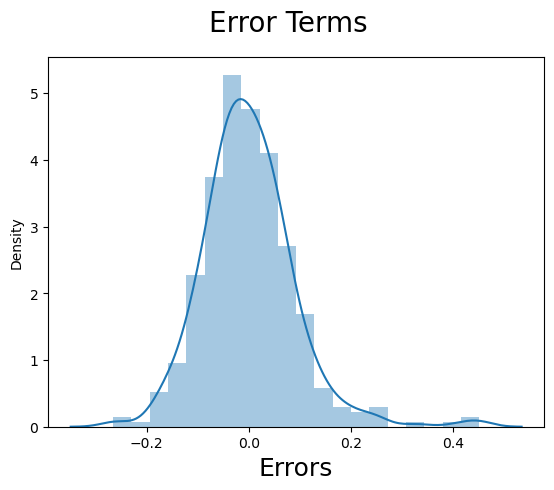

In [85]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Making Predictions

#### Applying the scaling on the test sets

In [86]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [87]:
y_test = df_test.pop('price')
X_test = df_test

In [88]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [89]:
# Making predictions
y_pred = lm.predict(X_test_new)

## Model Evaluation

Text(0, 0.5, 'y_pred')

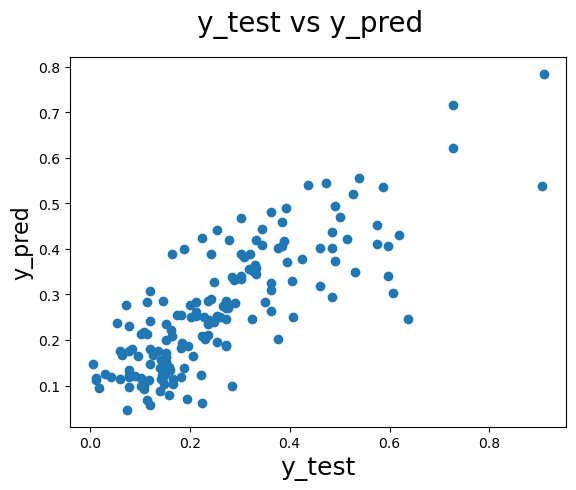

In [90]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [92]:
# The mean of residuals is always equal to zero

print(res.mean())
print(test_res.mean())

print(res.median())
print(test_res.median())

NameError: name 'res' is not defined